In [1]:
# %% Cell 1 — Install required packages (YAKE, RAKE, optional KeyBERT)
# YAKE + RAKE (rake-nltk) are lightweight. KeyBERT is optional (commented out).
!pip install --quiet yake rake-nltk
# Optional (uncomment if you want KeyBERT — slower & heavier)
# !pip install --quiet keybert sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 17.4 MB/s eta 0:00:00


In [2]:
# %% Cell 2 — NLTK downloads (needed for RAKE/tokenizers)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
# punkt_tab sometimes required in recent NLTK builds; download if needed
try:
    nltk.download('punkt_tab')
except:
    pass


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# %% Cell 3 — Imports & config
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# YAKE & RAKE imports
import yake
from rake_nltk import Rake

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# Optional KeyBERT variables (only used if you set USE_KEYBERT=True)
USE_KEYBERT = False
if USE_KEYBERT:
    from keybert import KeyBERT
    kw_model = KeyBERT(model="all-MiniLM-L6-v2")  # smaller / fast SBERT model


In [4]:
# %% Cell 4 — Load data
DATA_PATH = "/content/synthetic_bank_tweets_1500_with_names.csv"
df = pd.read_csv(DATA_PATH).reset_index(drop=True)
df['text'] = df['text'].astype(str)
print("Rows:", len(df))
df.head(3)


Rows: 1500


user_name       bank_name bank_type platform            timestamp  \
0    Manish       Axis Bank   Private  Twitter  2024-09-02T13:54:18   
1   Keerthi  Bank of Baroda    Public  Twitter  2025-11-02T21:48:45   
2      Amit      ICICI Bank   Private  Twitter  2025-10-15T04:53:45   

                                                text   category  \
0  Axis Bank offered helpful service at the branc...    service   
1  Can't complete payment on Bank of Baroda. UPI ...    failure   
2  Claimed an offer from ICICI Bank and it worked...  promotion   

   sentiment_score sentiment  likes  retweets  user_followers  is_reply  \
0           -0.194  negative      1         0            7640     False   
1           -0.439  negative      6         0           15511      True   
2            0.702  positive      3         0           18699     False   

   in_reply_to_bank_response  response_time_minutes          location  
0                       True                   70.0      Delhi, India  
1                       True                    5.0  Hyderabad, India  
2                       True                  120.0    Kolkata, India

In [6]:
!pip install --quiet vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.2 MB/s eta 0:00:00


In [7]:
# %% Cell 5 — Pre-filtering: choose scope for extraction
# We will extract keywords for:
# 1) All tweets
# 2) Negative tweets only (VADER-based)
# 3) Per bank_type (Public / Private)
# 4) Per category (failure, promotion, service, fraud) — if category exists

# If vader_label not present, compute VADER (safe list approach)
if 'vader_label' not in df.columns:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = [analyzer.polarity_scores(t)['compound'] for t in df['text'].tolist()]
    df['vader_compound'] = np.array(vader_scores)
    df['vader_label'] = df['vader_compound'].apply(lambda v: 'positive' if v>0.05 else ('negative' if v<-0.05 else 'neutral'))

# Create lowercase cleaned version for keyword extraction
def light_clean(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+',' ', s)
    s = re.sub(r'@\w+|#\w+',' ', s)
    s = re.sub(r'[^a-z0-9\s₹]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(light_clean)


In [8]:
# %% Cell 6 — Helper functions: YAKE, RAKE, KeyBERT wrappers
# YAKE wrapper
def yake_keywords(texts, n=20, max_ngram_size=3):
    # texts: list of documents (strings)
    combined = " \n ".join([t for t in texts if t])
    if not combined.strip():
        return []
    kw_extractor = yake.KeywordExtractor(lan="en", n=max_ngram_size, top=n)
    keywords = kw_extractor.extract_keywords(combined)
    # keywords is list of (keyphrase, score) sorted by score (lower is better)
    return [(k, round(float(v),6)) for k,v in keywords]

# RAKE wrapper (extract phrases per-doc then aggregate)
rake_extractor = Rake(language='english')
def rake_keywords(texts, top_n=30):
    counter = Counter()
    for t in texts:
        if not t.strip():
            continue
        rake_extractor.extract_keywords_from_text(t)
        phrases = rake_extractor.get_ranked_phrases()
        for p in phrases:
            counter[p] += 1
    return counter.most_common(top_n)

# KeyBERT wrapper (optional)
def keybert_keywords(texts, top_n=10, keyphrase_ngram_range=(1,3)):
    # returns aggregated keywords with scores (averaged)
    if not USE_KEYBERT:
        raise RuntimeError("KeyBERT not enabled. Set USE_KEYBERT=True and restart the cell.")
    docs = [t for t in texts if t.strip()]
    all_kws = []
    for d in docs:
        kws = kw_model.extract_keywords(d, keyphrase_ngram_range=keyphrase_ngram_range, top_n=top_n)
        all_kws.extend(kws)
    # aggregate by keyword (average score)
    agg = {}
    for k,score in all_kws:
        agg.setdefault(k,[]).append(score)
    agg_avg = [(k, sum(v)/len(v)) for k,v in agg.items()]
    agg_avg.sort(key=lambda x: -x[1])  # higher is better
    return agg_avg[:top_n]


In [9]:
# %% Cell 7 — Extract keywords globally (all tweets) using YAKE + RAKE
all_texts = df['text_clean'].tolist()

print("Running YAKE (global)...")
yake_all = yake_keywords(all_texts, n=40, max_ngram_size=3)
print("Top YAKE keywords (global):")
for k,s in yake_all[:20]:
    print(k, s)

print("\nRunning RAKE (global)...")
rake_all = rake_keywords(all_texts, top_n=40)
print("Top RAKE phrases (global):")
for p,c in rake_all[:20]:
    print(p, c)


Running YAKE (global)...
Top YAKE keywords (global):
hdfc bank app 1e-06
axis bank app 1e-06
icici bank app 1e-06
bank app shows 1e-06
bank upi timeout 1e-06
hdfc bank upi 1e-06
axis bank upi 1e-06
banks hdfc bank 1e-06
bank app crashed 1e-06
sbi banks bank 1e-06
banks axis bank 1e-06
bank upi money 1e-06
icici bank upi 1e-06
bank app today 2e-06
banks icici bank 2e-06
app shows error 2e-06
hdfc bank customer 2e-06
upi timeout happened 2e-06
bank customer service 2e-06
sbi banks sbi 2e-06

Running RAKE (global)...
Top RAKE phrases (global):
bank 226
transferring funds 89
upi failed 88
complete payment 85
frustrating 84
hdfc bank 83
long ivr wait time 83
help 80
chatbot 80
pnb 77
checkout 77
annoying 75
twitter 71
reached 71
branch 70
reply 68
online 67
transaction failed 67
axis bank 66
slower 63


In [10]:
# %% Cell 8 — Extract keywords for negative tweets only
neg_texts = df[df['vader_label']=='negative']['text_clean'].tolist()
print("Negative posts:", len(neg_texts))

yake_neg = yake_keywords(neg_texts, n=40, max_ngram_size=3)
rake_neg = rake_keywords(neg_texts, top_n=40)

print("Top YAKE keywords (negative):")
for k,s in yake_neg[:20]:
    print(k, s)

print("\nTop RAKE phrases (negative):")
for p,c in rake_neg[:20]:
    print(p, c)


Negative posts: 547
Top YAKE keywords (negative):
bank app shows 2e-06
app shows error 2e-06
ivr wait time 2e-06
long ivr wait 2e-06
bank upi money 2e-06
upi money debited 2e-06
hdfc bank app 3e-06
axis bank app 4e-06
icici bank app 4e-06
fraudulent transaction noticed 5e-06
alert fraudulent transaction 5e-06
axis bank upi 5e-06
hdfc bank support 6e-06
hdfc bank upi 6e-06
axis bank support 6e-06
bank app showing 7e-06
checkout upi failed 8e-06
icici bank upi 8e-06
app showing unknown 9e-06
sbi app shows 9e-06

Top RAKE phrases (negative):
upi failed 88
frustrating 84
long ivr wait time 83
bank 83
checkout 77
annoying 75
twitter 71
reached 71
reply 68
transaction failed 67
credited 62
transaction confirmation 61
delay 61
hdfc bank 49
baroda 47
pnb 45
axis bank 45
alert fraudulent transaction noticed 40
sbi 34
icici bank 28


In [11]:
# %% Cell 9 — Per bank_type keyword extraction (YAKE + RAKE)
bank_types = df['bank_type'].fillna('Unknown').unique().tolist()
bank_keywords = {}
for bt in bank_types:
    texts = df[df['bank_type'].fillna('Unknown')==bt]['text_clean'].tolist()
    bank_keywords[bt] = {
        'yake': yake_keywords(texts, n=25, max_ngram_size=3),
        'rake': rake_keywords(texts, top_n=25)
    }

# Display top 10 per bank_type (YAKE)
for bt, info in bank_keywords.items():
    print(f"\n=== Bank Type: {bt} (YAKE top 10) ===")
    for k,s in info['yake'][:10]:
        print(k, s)



=== Bank Type: Private (YAKE top 10) ===
hdfc bank app 0.0
axis bank app 1e-06
icici bank app 1e-06
banks hdfc bank 1e-06
banks axis bank 1e-06
hdfc bank upi 1e-06
axis bank upi 1e-06
bank app shows 1e-06
banks icici bank 1e-06
bank upi timeout 1e-06

=== Bank Type: Public (YAKE top 10) ===
sbi banks sbi 3e-06
sbi banks bank 3e-06
sbi app crashed 4e-06
sbi banks pnb 4e-06
app shows error 4e-06
upi timeout happened 4e-06
sbi app shows 5e-06
sbi upi timeout 5e-06
pnb app crashed 5e-06
bank of baroda 6e-06


In [12]:
# %% Cell 10 — Per category keyword extraction (if category exists)
if 'category' in df.columns:
    cats = df['category'].dropna().unique().tolist()
    cat_keywords = {}
    for cat in cats:
        texts = df[df['category']==cat]['text_clean'].tolist()
        cat_keywords[cat] = {
            'yake': yake_keywords(texts, n=25, max_ngram_size=3),
            'rake': rake_keywords(texts, top_n=25)
        }
    # print example
    for cat,info in cat_keywords.items():
        print(f"\n=== Category: {cat} (YAKE top 8) ===")
        for k,s in info['yake'][:8]:
            print(k, s)
else:
    print("No 'category' column found — skip category-level extraction.")



=== Category: service (YAKE top 8) ===
ivr wait time 2e-06
long ivr wait 2e-06
offered helpful service 2e-06
customer service resolved 3e-06
bank customer service 3e-06
bank offered helpful 3e-06
hdfc bank support 5e-06
axis bank support 6e-06

=== Category: failure (YAKE top 8) ===
upi timeout happened 2e-06
app shows error 2e-06
bank upi timeout 2e-06
bank app shows 2e-06
upi money debited 2e-06
bank app crashed 2e-06
bank upi money 3e-06
hdfc bank app 3e-06

=== Category: promotion (YAKE top 8) ===
promo gave instant 3e-06
gave instant discount 3e-06
bank promo gave 3e-06
instant discount impressive 4e-06
bank app today 4e-06
tempting good job 4e-06
hdfc bank promo 8e-06
axis bank app 1e-05

=== Category: fraud (YAKE top 8) ===
fraudulent transaction noticed 3e-06
alert fraudulent transaction 3e-06
phishing attempt related 4e-06
showing unknown beneficiary 6e-06
app showing unknown 6e-06
bank app showing 8e-06
bank customer care 1e-05
suspicious message claiming 1.2e-05

=== Catego

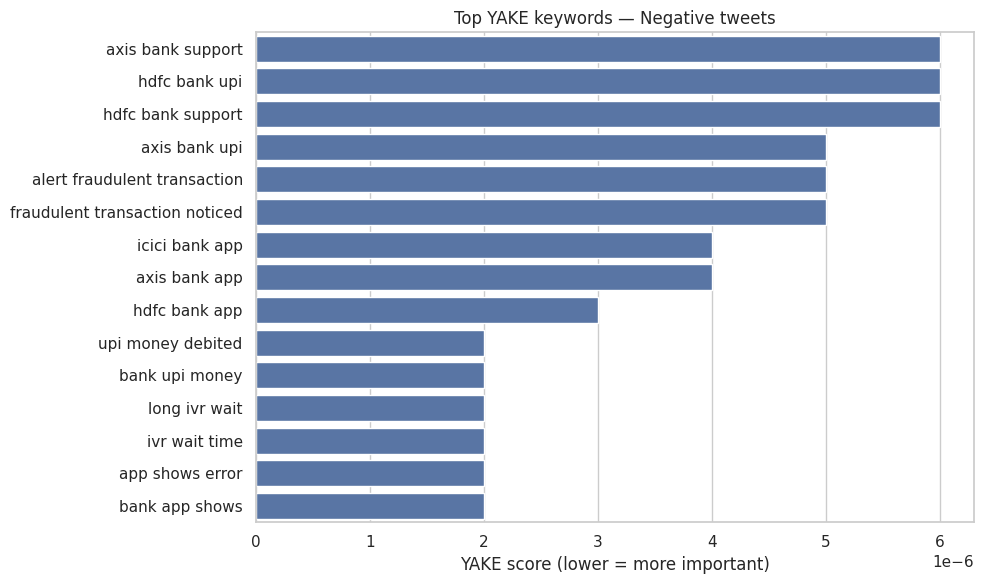

In [13]:
# %% Cell 11 — Visualize top keywords from negative tweets (YAKE)
top_yake_neg = [k for k,s in yake_neg[:15]]
top_yake_neg_scores = [s for k,s in yake_neg[:15]]

plt.figure(figsize=(10,6))
sns.barplot(x=top_yake_neg_scores[::-1], y=top_yake_neg[::-1])
plt.xlabel("YAKE score (lower = more important)")
plt.title("Top YAKE keywords — Negative tweets")
plt.tight_layout()
plt.show()


In [15]:
# %% Cell 13 — OPTIONAL: Run KeyBERT (if USE_KEYBERT=True)
if USE_KEYBERT:
    print("Running KeyBERT (this may take time)...")
    kb_all = keybert_keywords(all_texts, top_n=20)
    print("KeyBERT top keywords (global):")
    for k,s in kb_all:
        print(k, round(s,4))
    kb_neg = keybert_keywords(neg_texts, top_n=20)
    print("\nKeyBERT top keywords (negative):")
    for k,s in kb_neg:
        print(k, round(s,4))
else:
    print("KeyBERT disabled — set USE_KEYBERT = True to enable (heavy install).")


KeyBERT disabled — set USE_KEYBERT = True to enable (heavy install).
